# **(ADD THE NOTEBOOK NAME HERE)**

## Objectives

* Start Stastical testing using the cleaned CSV file in the Processed folder 

## Inputs

* Import Sci-kit learn for Machine Learning/feature engine

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ngubo\\Documents\\vscode-projects\\Capstone_Project_Fruit_Veg_Prices_UK\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ngubo\\Documents\\vscode-projects\\Capstone_Project_Fruit_Veg_Prices_UK'

# Section 1

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### PCA
from sklearn.decomposition import PCA

### ML algorithm
from sklearn.cluster import KMeans

# Load the cleaned dataset
df = pd.read_csv('Dataset/Processed/fruitvegprices-2017_2022-cleaned.csv')

Create a 'Season' column and run ANOVA test to see if price differs by season 

In [5]:
from scipy.stats import f_oneway 

# convert date column
df['date'] = pd.to_datetime(df['date'])

# Define seasons by month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['date'].dt.month.apply(get_season)

# Run ANOVA across seasons
groups = [df[df['season'] == s]['price'] for s in df['season'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.3f}")

ANOVA F-statistic: 77.660, p-value: 0.000


In [6]:
# One-hot encode season for ML model
df = pd.get_dummies(df, columns=['season'], drop_first=True)

In [7]:
# Create lag features for price (e.g., previous day's price)
df = df.sort_values(['item', 'date'])
df['price_lag_1'] = df.groupby('item')['price'].shift(1)
df = df.dropna(subset=['price_lag_1'])  # drop rows where lag is missing

In [8]:
# Define features and target
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

features = ['price_lag_1'] + [col for col in df.columns if col.startswith('season_')]
target = 'price'

# Split by date for train/test
cutoff_date = '2021-12-31'
train = df[df['date'] <= cutoff_date]
test = df[df['date'] > cutoff_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"Test MAE: {mae:.2f}")

c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboo

Test MAE: 0.22


c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboo

Visualize Predictions vs Actual Prices 

C:\Users\ngubo\AppData\Local\Temp\ipykernel_82720\706921275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_price'] = preds


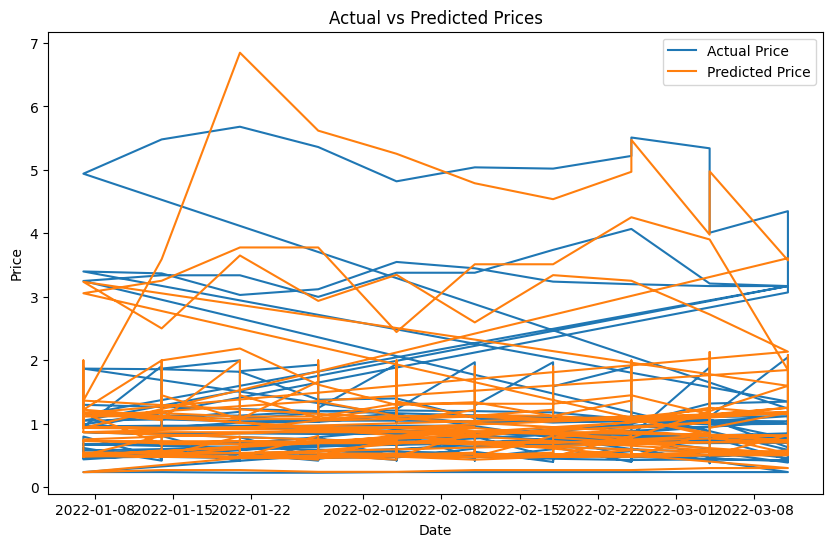

In [ ]:
# Plot predicted vs actual prices

test['predicted_price'] = preds
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test['price'], label='Actual Price')
plt.plot(test['date'], test['predicted_price'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

Run Classification to target price movement

In [10]:
# Sort values so shift works correctly
df = df.sort_values(['item', 'date'])

# Create next month price and target variable
df['price_next'] = df.groupby('item')['price'].shift(-1)

# Target: 1 if price next month > current price, else 0
df['price_movement'] = (df['price_next'] > df['price']).astype(int)

# Drop last rows per item where price_next is NaN
df = df.dropna(subset=['price_next', 'price_lag_1'])

In [ ]:
# Define features and target for classification
features = ['price_lag_1'] + [col for col in df.columns if col.startswith('season_')]
target = 'price_movement'

In [ ]:
# Split by date for train/test
cutoff_date = '2021-12-31'
train = df[df['date'] <= cutoff_date]
test = df[df['date'] > cutoff_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

Train a classifier

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Test Accuracy: {acc:.3f}")

print(classification_report(y_test, preds))

c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboo

Test Accuracy: 0.518
              precision    recall  f1-score   support

           0       0.60      0.50      0.54       165
           1       0.44      0.55      0.49       119

    accuracy                           0.52       284
   macro avg       0.52      0.52      0.52       284
weighted avg       0.53      0.52      0.52       284



c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ngubo\Documents\vscode-projects\Capstone_Project_Fruit_Veg_Prices_UK\.venv\Lib\site-packages\xgboo

Confusion matrix plot

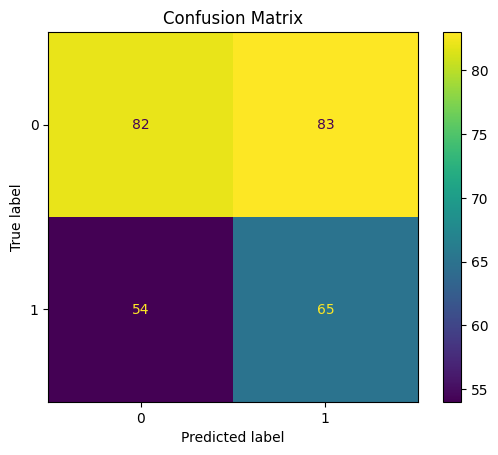

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title('Confusion Matrix')
plt.show()

Section 1 content

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---